In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal

import discfilter

In [2]:
def ramp(x, per=4):
    return ((x%per < per/2)*(x%per) + (x%per >= per/2)*(-x%per))/2

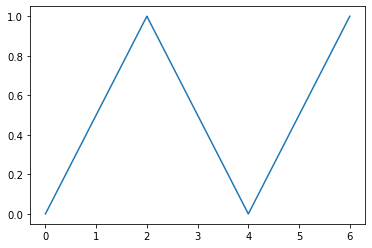

In [3]:
x = np.linspace(0,6,10_000)
y = ramp(x, per=4)
plt.plot(x,y)

In [4]:
def loren(x, cent=0.0, width=1.0):
    return 1.0/(1.0 + (x-cent)**2/width**2)

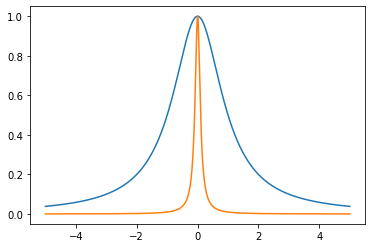

In [5]:
x = np.linspace(-5,5,10_000)
plt.plot(x, loren(x, width=1.0))
plt.plot(x, loren(x, width=0.1))

In [6]:
def absorp(nu, optical_depth=1.0, cent=1.0, width=0.2):
    return np.exp(-optical_depth*loren(nu, cent=cent, width=width))

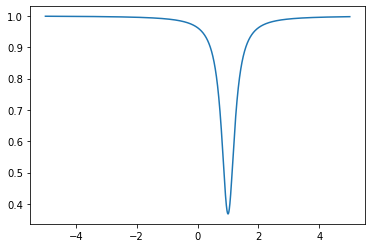

In [7]:
plt.plot(x, absorp(x, cent=1))

In [8]:
OMEGA_MOD = 1_000_000 * 2*np.pi
MOD_DEPTH = 0.01
I_DEPTH = 0.3
INTENSITY_PHASE = 0.1

t=np.linspace(0,2,125_000_000)
nu = MOD_DEPTH * np.sin(OMEGA_MOD*t) + ramp(t)   # Laser optical frequency detuning
li = 1 + I_DEPTH * nu                            # Laser intensity

lr = absorp(nu, cent=0.5, width=0.02, optical_depth=0.1)*li

In [ ]:
plt.plot(t, li, label='Outgoing Intensity')
plt.plot(t, lr, label='Return Intensity')
plt.legend()

In [9]:
def lowPassFilter(y,freq=0.000002,order=2):
    transferNumerator, transferDenominator = scipy.signal.butter(order,freq,'lowpass')
    y = scipy.signal.lfilter(transferNumerator,transferDenominator,y)
    return y

def decimate(y, decimation):
    return y[0::decimation]

def lock_in(y, ref_phase):
    i_1f = np.sin(ref_phase)
    q_1f = np.cos(ref_phase)
    i_2f = np.sin(2*ref_phase)
    q_2f = np.cos(2*ref_phase)
    
    out_data = (lowPassFilter(y*i_1f),
                lowPassFilter(y*q_1f),
                lowPassFilter(y*i_2f),
                lowPassFilter(y*q_2f))
    return out_data

def lock_in_dec(y, ref_phase, decimation = 4000):
    i_1f = np.sin(ref_phase)
    q_1f = np.cos(ref_phase)
    i_2f = np.sin(2*ref_phase)
    q_2f = np.cos(2*ref_phase)
    
    out_data = [lowPassFilter(y*i_1f, freq=0.01/decimation),
                lowPassFilter(y*q_1f, freq=0.01/decimation),
                lowPassFilter(y*i_2f, freq=0.01/decimation),
                lowPassFilter(y*q_2f, freq=0.01/decimation)]
    for i, d in enumerate(out_data):
        out_data[i] = decimate(d, decimation)
    return out_data

def lock_in_dec2(y, ref_phase, decimation = 4000):
    i_1f = np.sin(ref_phase)
    q_1f = np.cos(ref_phase)
    i_2f = np.sin(2*ref_phase)
    q_2f = np.cos(2*ref_phase)
    
    alpha = discfilter.alpha(OMEGA_MOD/2/np.pi/50, t[1]-t[0])
    
    
    out_data = [discfilter.lpf2(y*i_1f, alpha),
                discfilter.lpf2(y*q_1f, alpha),
                discfilter.lpf2(y*i_2f, alpha),
                discfilter.lpf2(y*q_2f, alpha)]
    for i, d in enumerate(out_data):
        out_data[i] = decimate(d, decimation)
    return out_data

def lock_in_dec3(y, ref_phase):
    i_1f = np.sin(ref_phase)
    q_1f = np.cos(ref_phase)
    i_2f = np.sin(2*ref_phase)
    q_2f = np.cos(2*ref_phase)
    
    def lpf(x, freq):
        b, a = scipy.signal.butter(2,freq)
        return scipy.signal.lfilter(b,a,x)
    
    y1 = lpf(y,0.1)
    
    
    out_data = [lpf(y*i_1f),
                lpf(y*q_1f),
                lpf(y*i_2f),
                lpf(y*q_2f)]
    for i, d in enumerate(out_data):
        out_data[i] = decimate(d, decimation)
    return out_data

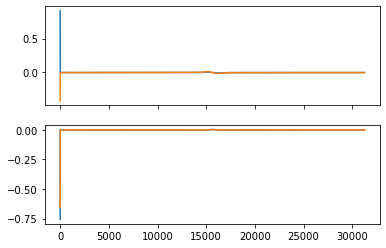

In [10]:
i_1f, q_1f, i_2f, q_2f = lock_in_dec2(lr, OMEGA_MOD*t + 2)
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(i_1f)
ax1.plot(q_1f)
ax2.plot(i_2f)
ax2.plot(q_2f)

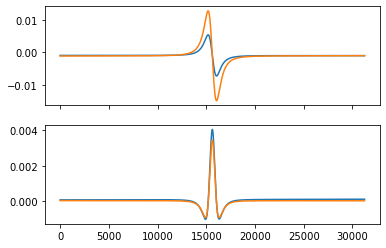

In [11]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(i_1f[10::])
ax1.plot(q_1f[10::])
ax2.plot(i_2f[10::])
ax2.plot(q_2f[10::])